# Bank marketing Analysis

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kendalltau
import pickle
import plotly.express  as px 
import tensorflow as tf
import glob
import os


# preprocessing
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from feature_engine.outliers import Winsorizer , OutlierTrimmer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#import machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import accuracy_score #metrics

#tools for hyperparameters search
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#Untuk mengabaikan fitur peringatan
import warnings
warnings.filterwarnings('ignore')

print("Import Berhasil")


Import Berhasil


In [2]:
# Load dataset
df = pd.read_csv('bank.csv')


In [3]:
# Melihat beberapa baris pertama
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
# Melihat informasi umum tentang dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [5]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [6]:
# Mengecek data duplicate 
df.duplicated().sum()


0

In [7]:
# Handling Missing Value
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

- Tidak ada missing value.

# Analisis Univariate
* Analisis Univariate adalah analisis satu variabel pada satu waktu. Di sini, kita akan menganalisis distribusi dan karakteristik dari masing-masing variabel.


 Distribusi Variabel Numerik.

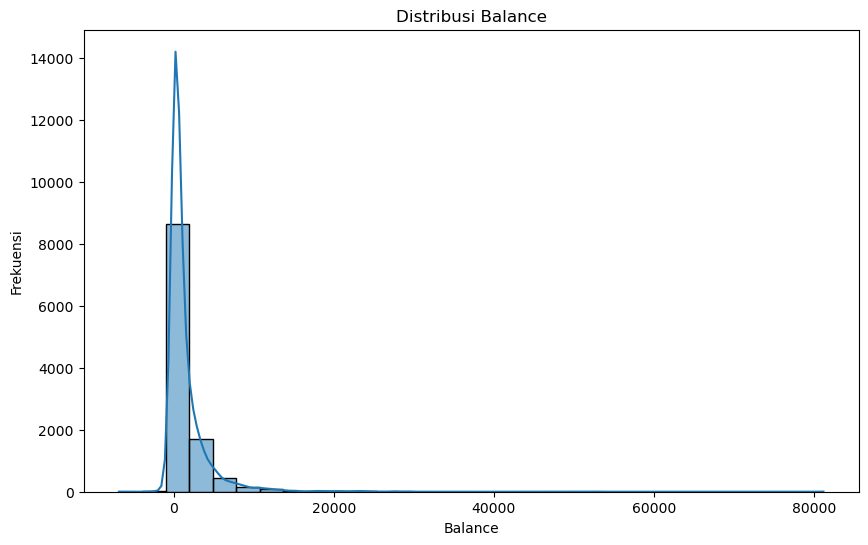

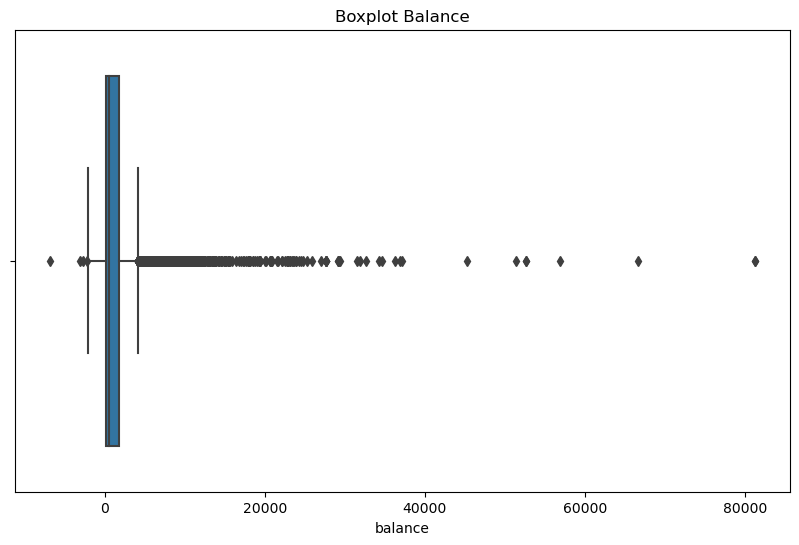

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df['balance'], kde=True, bins=30)
plt.title('Distribusi Balance')
plt.xlabel('Balance')
plt.ylabel('Frekuensi')
plt.show()

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['balance'])
plt.title('Boxplot Balance')
plt.show()


Kesimpulan:

- Histogram menunjukkan bahwa sebagian besar nasabah memiliki saldo di bawah beberapa ribu unit (tergantung mata uang).
- Boxplot menunjukkan ada beberapa outlier (saldo sangat tinggi) yang mungkin perlu dianalisis lebih lanjut, karena mereka mungkin mempengaruhi hasil model nantinya.

Distribusi Job.

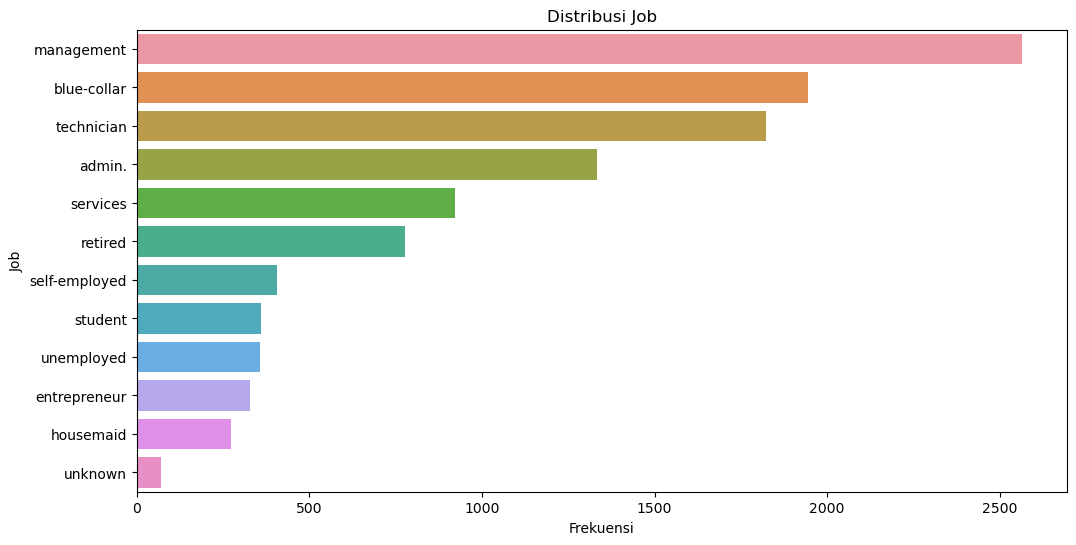

In [9]:
plt.figure(figsize=(12, 6))
sns.countplot(y=df['job'], order=df['job'].value_counts().index)
plt.title('Distribusi Job')
plt.xlabel('Frekuensi')
plt.ylabel('Job')
plt.show()


Kesimpulan:

- Mayoritas nasabah bekerja sebagai management, blue-collar, dan technician.
- Ini bisa memberikan insight tentang kelompok pekerjaan mana yang lebih sering menggunakan layanan bank tertentu.

# Analisis Bivariate
* Analisis Bivariate adalah analisis hubungan antara dua variabel. Di sini, kita akan melihat bagaimana setiap variabel berhubungan dengan variabel target kita, yaitu 'deposit'.

Korelasi Antar Variabel Numerik.

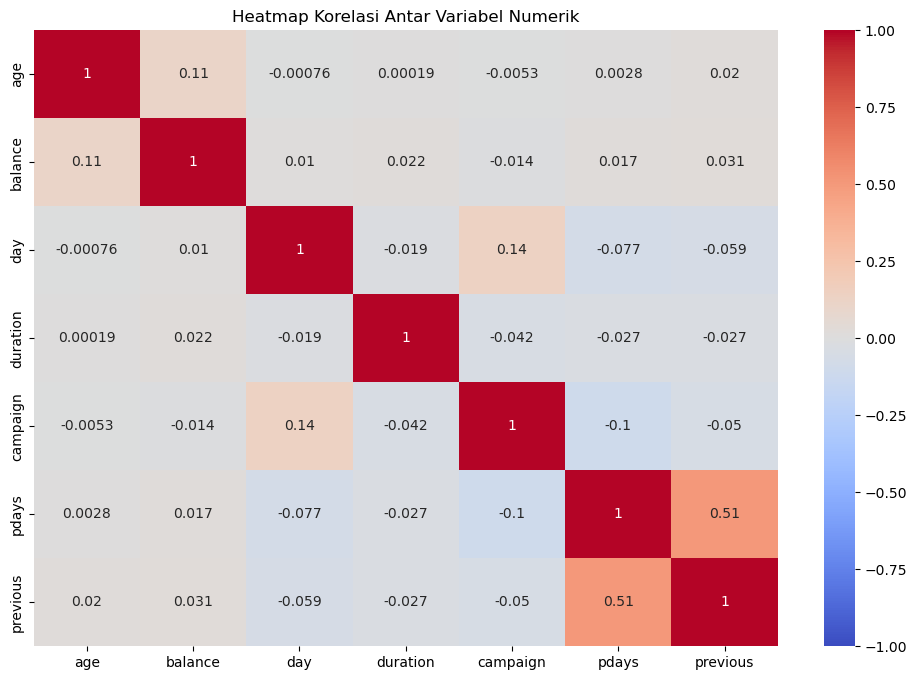

In [10]:
# Pilih hanya kolom numerik
numerical_df = df.select_dtypes(include=['int64', 'float64'])

# Hitung korelasi
plt.figure(figsize=(12, 8))
correlation = numerical_df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap Korelasi Antar Variabel Numerik')
plt.show()


Boxplot untuk  memahami distribusi variabel deposit dan balance.

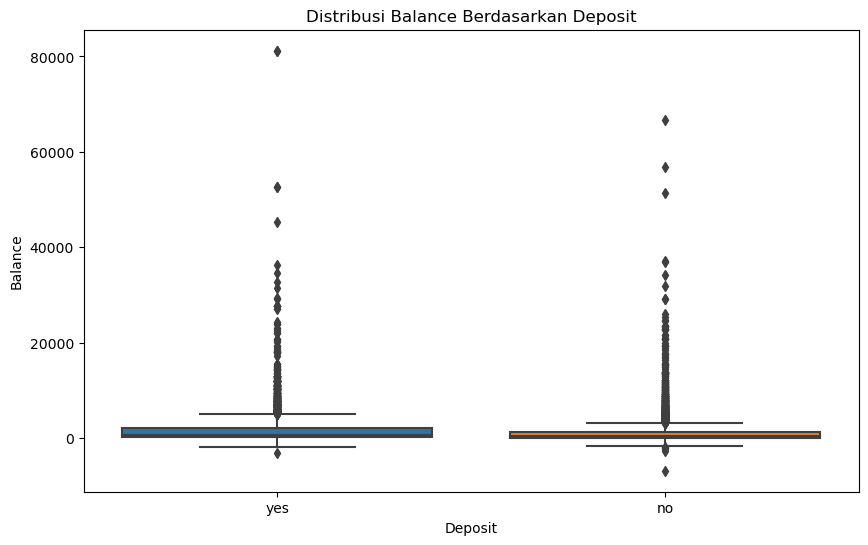

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='deposit', y='balance', data=df)
plt.title('Distribusi Balance Berdasarkan Deposit')
plt.xlabel('Deposit')
plt.ylabel('Balance')
plt.show()


Kesimpulan:

- Boxplot ini menunjukkan bagaimana distribusi balance berbeda antara nasabah yang membuka deposito (yes) dan yang tidak (no).
- Jika balance untuk yes secara signifikan lebih tinggi, ini menunjukkan bahwa nasabah dengan saldo lebih tinggi cenderung lebih mungkin untuk membuka deposito.

Violin plot memberikan informasi tentang distribusi dan kepadatan data, mirip dengan boxplot tapi lebih detail. Ini bisa digunakan untuk variabel seperti duration.

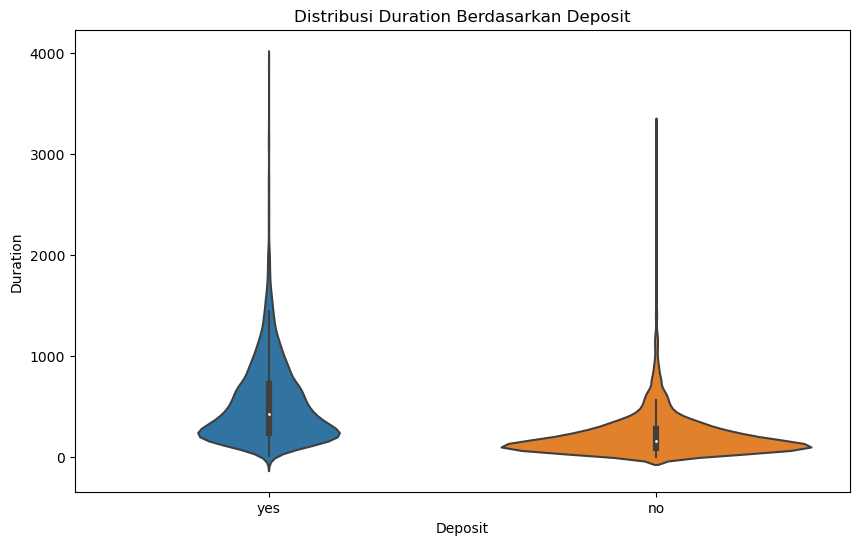

In [12]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='deposit', y='duration', data=df)
plt.title('Distribusi Duration Berdasarkan Deposit')
plt.xlabel('Deposit')
plt.ylabel('Duration')
plt.show()


Kesimpulan:

- Violin plot ini menunjukkan distribusi duration (lama panggilan) antara mereka yang membuka deposito dan yang tidak.
- Jika durasi lebih panjang lebih sering terkait dengan deposito, ini bisa menunjukkan bahwa panggilan yang lebih lama cenderung lebih efektif dalam mengonversi nasabah.

Bar plot untuk melihat bagaimana variabel kategorikal seperti job berhubungan dengan deposit.

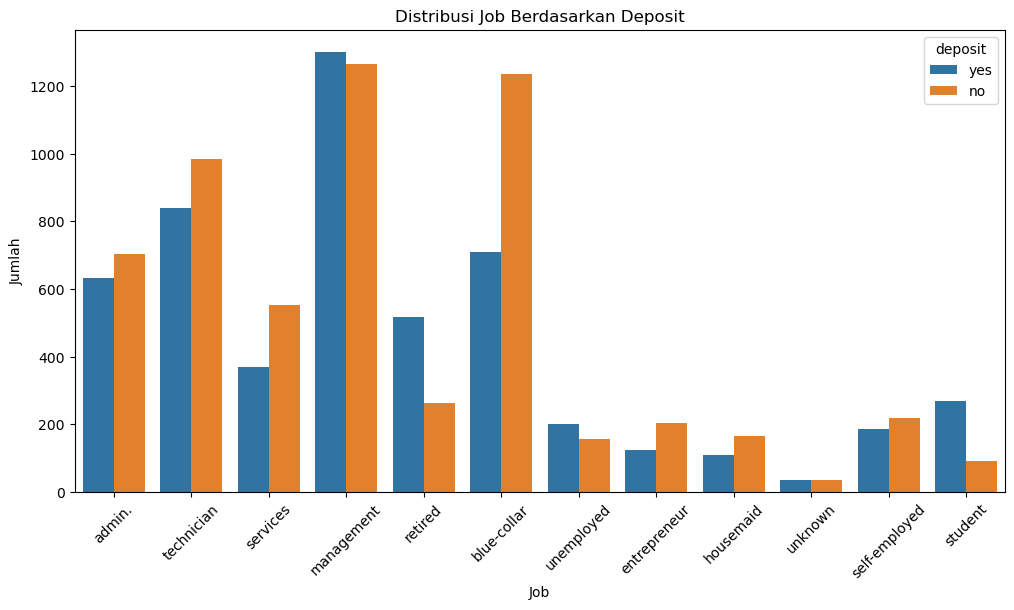

In [13]:
plt.figure(figsize=(12, 6))
sns.countplot(x='job', hue='deposit', data=df)
plt.title('Distribusi Job Berdasarkan Deposit')
plt.xlabel('Job')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.show()


Kesimpulan:

- Bar plot ini menunjukkan bagaimana pekerjaan (job) berbeda mempengaruhi kemungkinan nasabah membuka deposito (yes) atau tidak (no).
- Jika ada pekerjaan tertentu yang memiliki lebih banyak yes, ini bisa menjadi target potensial untuk kampanye deposito.

## Kesimpulan Visualisasi
Setelah melakukan analisis di atas, Anda bisa menarik kesimpulan tentang faktor-faktor yang paling mempengaruhi keputusan nasabah untuk membuka deposito berjangka. Misalnya:

- Nasabah dengan saldo tinggi (balance) lebih mungkin untuk membuka deposito.
- Pekerjaan tertentu (job) seperti management memiliki tingkat konversi deposito yang lebih tinggi.
- Durasi panggilan (duration) yang lebih lama tampaknya meningkatkan kemungkinan keberhasilan dalam membuka deposito.

Pairplot untuk menganalisis hubungan antar beberapa variabel sekaligus.

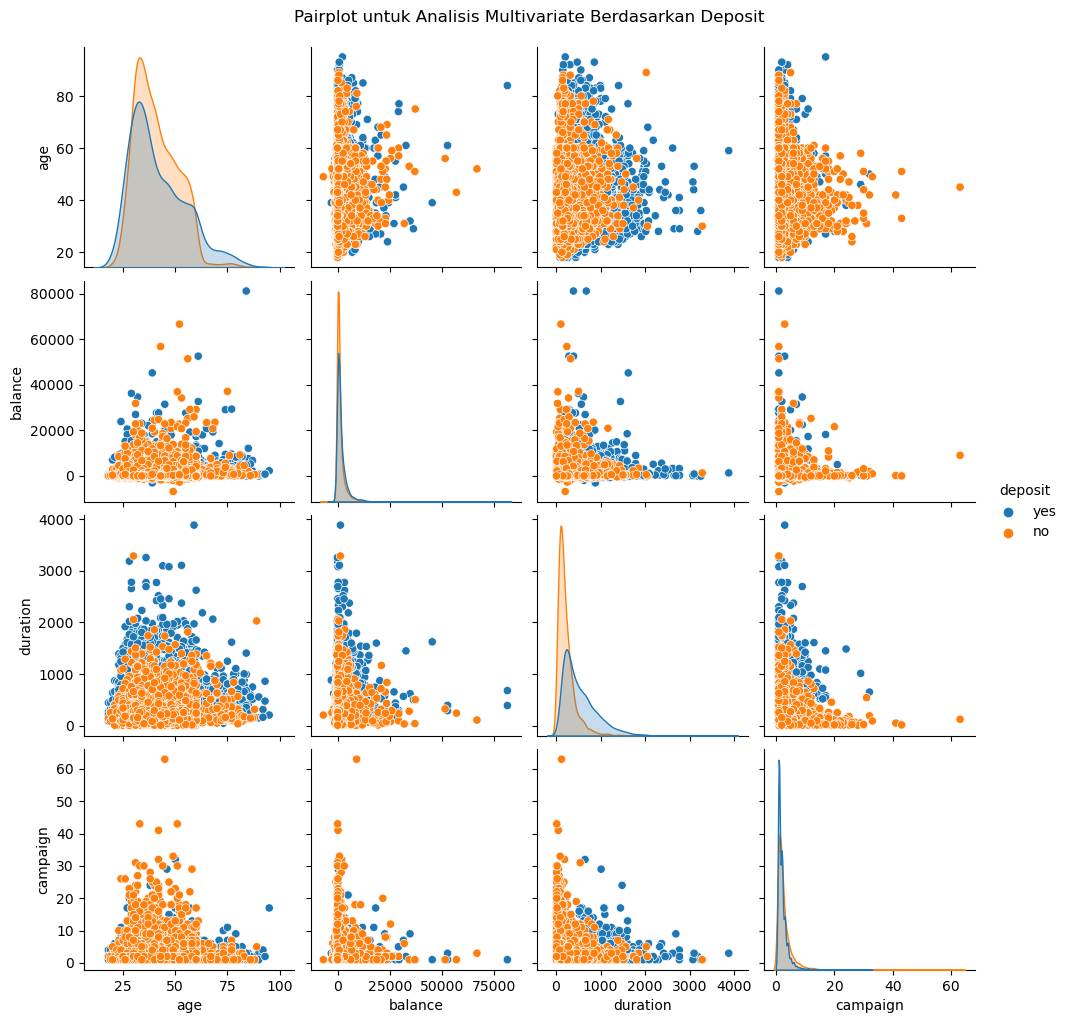

In [14]:
sns.pairplot(df, hue='deposit', vars=['age', 'balance', 'duration', 'campaign'])
plt.suptitle('Pairplot untuk Analisis Multivariate Berdasarkan Deposit', y=1.02)
plt.show()


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Langkah 1: Siapkan Data
# Pilih variabel numerik yang relevan
X = df[['age', 'balance', 'duration', 'campaign']]  # Pilih variabel yang Anda inginkan
# Ubah kolom 'deposit' menjadi numerik
y = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

# Langkah 2: Pisahkan data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Langkah 3: Inisiasi dan latih model regresi logistik
model = LogisticRegression()
model.fit(X_train, y_train)

# Langkah 4: Prediksi menggunakan data testing
y_pred = model.predict(X_test)

# Langkah 5: Evaluasi model
print(confusion_matrix(y_test, y_pred))  # Matrix yang menunjukkan hasil prediksi vs aktual
print(classification_report(y_test, y_pred))  # Laporan yang lebih lengkap tentang performa model


[[1439  303]
 [ 645  962]]
              precision    recall  f1-score   support

           0       0.69      0.83      0.75      1742
           1       0.76      0.60      0.67      1607

    accuracy                           0.72      3349
   macro avg       0.73      0.71      0.71      3349
weighted avg       0.72      0.72      0.71      3349



Kesimpulan:

- Model ini akan membantu Anda mengidentifikasi variabel mana yang paling signifikan dalam mempengaruhi keputusan nasabah untuk membuka deposito.
- Evaluasi model, seperti confusion matrix dan classification report, memberi Anda wawasan tentang seberapa baik model bekerja dan seberapa akurat prediksinya.

Catatan;
- Confusion Matrix: Matrix ini menunjukkan berapa banyak prediksi benar dan salah yang dilakukan oleh model. Ini memberi Anda gambaran tentang seberapa akurat model.
- Classification Report: Ini akan memberi Anda metrik seperti precision, recall, dan f1-score, yang membantu Anda memahami seberapa baik model dalam memprediksi yes atau no untuk deposit.

Kesimpulan Singkat
1. Model Kinerja Umum:

- Model memiliki akurasi sebesar 72%, yang menunjukkan bahwa model ini memprediksi dengan benar sekitar 72% dari semua kasus.

2. Kinerja per Kelas:

- Kelas 0 (tidak deposit) memiliki recall yang lebih tinggi (83%) dibandingkan dengan Kelas 1 (deposit) (60%). Ini berarti model lebih baik dalam mendeteksi nasabah yang tidak membuka deposito.
- Precision lebih tinggi untuk Kelas 1 (76%), menunjukkan bahwa ketika model memprediksi nasabah akan membuka deposito, prediksi tersebut cenderung benar.

3. F1-Score:

- F1-score menunjukkan bahwa model memiliki kinerja yang relatif baik dalam mendeteksi kedua kelas, tetapi ada ruang untuk perbaikan, terutama untuk kelas 1 (deposit).

4. Macro vs. Weighted Average:

- Macro average menunjukkan kinerja model tanpa mempertimbangkan ketidakseimbangan kelas. Weighted average memberikan gambaran yang lebih akurat tentang kinerja model pada dataset yang tidak seimbang.

Saran untuk Perbaikan:

- Pertimbangkan untuk menyeimbangkan kelas (misalnya dengan teknik oversampling untuk kelas minoritas atau undersampling untuk kelas mayoritas).
- Eksplorasi model yang berbeda atau teknik tuning untuk meningkatkan recall pada kelas 1 (deposit) tanpa mengorbankan akurasi kelas 0 (tidak deposit).

## Memperbaiki dari penyeimbanakan kelas.

a. Oversampling Kelas Minoritas

In [16]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Pisahkan fitur dan target
X = df[['age', 'balance', 'duration', 'campaign']]
y = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

# Pisahkan data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Terapkan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Latih model menggunakan data yang telah di-resample
model = LogisticRegression()
model.fit(X_resampled, y_resampled)

# Prediksi dan evaluasi
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[1385  357]
 [ 596 1011]]
              precision    recall  f1-score   support

           0       0.70      0.80      0.74      1742
           1       0.74      0.63      0.68      1607

    accuracy                           0.72      3349
   macro avg       0.72      0.71      0.71      3349
weighted avg       0.72      0.72      0.71      3349



b. Undersampling Kelas Mayoritas

In [17]:
from imblearn.under_sampling import RandomUnderSampler

# Terapkan RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

# Latih model menggunakan data yang telah di-resample
model = LogisticRegression()
model.fit(X_resampled, y_resampled)

# Prediksi dan evaluasi
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[1384  358]
 [ 595 1012]]
              precision    recall  f1-score   support

           0       0.70      0.79      0.74      1742
           1       0.74      0.63      0.68      1607

    accuracy                           0.72      3349
   macro avg       0.72      0.71      0.71      3349
weighted avg       0.72      0.72      0.71      3349



Kesimpulan
- Oversampling dan undersampling menghasilkan hasil yang hampir identik dalam hal metrik evaluasi utama (precision, recall, F1-score, akurasi).
- Oversampling memberikan sedikit peningkatan dalam recall untuk kelas 0, sedangkan undersampling memberikan sedikit peningkatan dalam recall untuk kelas 1.
- Pemilihan Teknik: Jika Anda ingin fokus pada meningkatkan recall untuk kelas 1 (deposit), teknik undersampling sedikit lebih baik. Namun, jika Anda ingin kinerja yang lebih seimbang di antara kelas-kelas, oversampling adalah pilihan yang baik.

Keduanya adalah metode yang valid untuk menangani ketidakseimbangan kelas, dan hasilnya menunjukkan bahwa model Anda dapat menangani ketidakseimbangan dengan baik setelah menggunakan teknik ini. 

## Model dan Teknik Lainnya

a. Grid Search untuk Hyperparameter Tuning

In [18]:
from sklearn.model_selection import GridSearchCV

# Tentukan parameter grid
param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'saga']  # Solver options
}

# Inisiasi model dan GridSearchCV
model = LogisticRegression()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Lihat parameter terbaik dan evaluasi
print(grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


{'C': 0.1, 'solver': 'liblinear'}
[[1430  312]
 [ 642  965]]
              precision    recall  f1-score   support

           0       0.69      0.82      0.75      1742
           1       0.76      0.60      0.67      1607

    accuracy                           0.72      3349
   macro avg       0.72      0.71      0.71      3349
weighted avg       0.72      0.72      0.71      3349



b. Coba Model Lain Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Inisiasi dan latih Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Prediksi dan evaluasi
y_pred = rf_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[1292  450]
 [ 428 1179]]
              precision    recall  f1-score   support

           0       0.75      0.74      0.75      1742
           1       0.72      0.73      0.73      1607

    accuracy                           0.74      3349
   macro avg       0.74      0.74      0.74      3349
weighted avg       0.74      0.74      0.74      3349



## Validasi dan Interpretasi Model

 Cross-Validation

In [20]:
from sklearn.model_selection import cross_val_score

# Cross-validation dengan model terbaik
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='f1')
print(f'Cross-validation F1 Scores: {cv_scores}')
print(f'Mean F1 Score: {cv_scores.mean()}')


Cross-validation F1 Scores: [0.85428051 0.70292458 0.48322981 0.52576723 0.66597294]
Mean F1 Score: 0.6464350143284199


Kesimpulan Cross-Validation
- Skor F1 Per Fold:
Skor F1 model bervariasi antara 0.483 dan 0.854 di berbagai lipatan data.
- Mean F1 Score:
Rata-rata skor F1 adalah 0.646, menunjukkan model memiliki kinerja yang baik secara keseluruhan, tetapi ada variabilitas dalam performa di berbagai subset data.

Interpretasi Koefisien Model: Untuk regresi logistik, interpretasi koefisien model untuk memahami pengaruh relatif dari setiap variabel terhadap probabilitas deposit.

In [21]:
# Interpretasi koefisien
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(coefficients)


    Feature  Coefficient
2  duration     0.004366
0       age     0.000390
1   balance     0.000050
3  campaign    -0.155893


- duration:
Setiap penambahan satu unit durasi kontak meningkatkan kemungkinan deposito. Ini adalah faktor paling signifikan.
- age dan balance:
Memiliki pengaruh positif kecil terhadap keputusan deposito, tetapi tidak signifikan besar.
- campaign:
Jumlah kontak yang lebih banyak selama kampanye mengurangi kemungkinan deposito, menunjukkan bahwa lebih banyak kontak mungkin tidak efektif.

Inti Kesimpulan:

Model tersebut menunjukkan kinerja rata-rata yang baik dengan beberapa variabilitas. Durasi kontak adalah faktor paling penting untuk mempengaruhi keputusan deposito, sementara jumlah kontak dalam kampanye mungkin perlu dikurangi untuk efektivitas yang lebih baik.

## Visualisasi dan Penyampaian Hasil

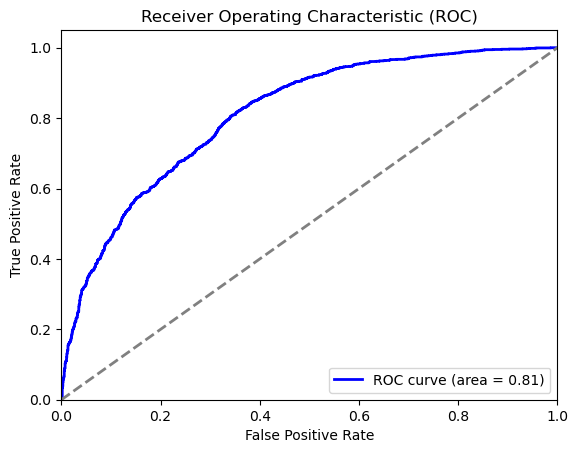

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Plot ROC Curve
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


Kesimpulan:

- ROC Curve dan AUC menunjukkan bahwa model tersebut memiliki kemampuan yang baik untuk memisahkan antara kelas deposit dan non-deposit. Semakin tinggi nilai AUC, semakin baik model dalam memprediksi kemungkinan deposit dengan akurat.